`Created by Ayushi Dubey`

**Task T3 Performance:** can we check if the model gives accurate results in external datasets? This is more time consuming and will be done by identifying a public dataset that has not been used in model training, and running predictions to build AUROC curves - to simplify reports, we will only focus on AUROC or R2 as metrics now.

**Task Description:**

This is a continuation from the efforts of Week 2. During this week, you will work with the mentors to find a dataset for which:

- We have experimental results on the activity we are trying to predict (for example, malaria IC50)

- There is no "data leakage", ie, molecules in this dataset are not in the training set of the model. This is a very important check!

Once the dataset is curated and cleaned, we can run predictions and create performance metrics like AUROC curves.

# Data Chosen for External Validation:

For validating the model in the wild, I chose the hERG blockers test data used by Li et al in their paper titled "Modeling of the hERG K+ Channel Blockage Using Online Chemical Database and Modeling Environment (OCHEM)".

The dataset contains 1092 records in which 234 records are hERG blockers and the rest are non-blockers.

- The paper can be viewed [here](https://onlinelibrary.wiley.com/doi/10.1002/minf.201700074). To view full paper click [here](https://acrobat.adobe.com/id/urn:aaid:sc:ap:01ce6a64-01b1-4369-a583-84e1c8da5015).
- The datasets used in the paper can be viewed [here](https://ochem.eu/login/show.do?render-mode=full)

# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from rdkit import Chem
from rdkit.Chem.ChemUtils import SDFToCSV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, r2_score, confusion_matrix, roc_curve
import json
import sys
sys.path.append('../src')
from smiles_processing import standardise_smiles
from inchikey_processing import standardise_inchikey
from pca_external_validation import calculate_morgan_fingerprints, perform_pca

# Exploring External Dataset

## Loading external dataset

In [2]:
external_data = pd.read_csv('../data/external_dataset.csv')
external_data.head()

,SMILES,CASRN,EXTERNALID,N,NAME,ARTICLEID,PUBMEDID,PAGE,TABLE,hERG K+ Channel Blocking
0,FC1=CC=C(C=C1)C(OCC[N+]2CC[N+](CC2)CCCC3=CC=CC...,-,-,1,-,A103592,28857516,-,-,yes
1,CC1CCCN1CCC2=CC3=CC(C4=CN=CC(C#N)=C4)=CC=C3O2,-,-,2,-,A103592,28857516,-,-,yes
2,COC1=NC=C(C2=CC=C(C3CC(N4CCCC4C)C3)C=C2)C=N1,-,-,3,-,A103592,28857516,-,-,yes
3,COC1=NC=C(C2=CC=C3C=C(CCN4CCCC4C)C=CC3=C2)C=N1,-,-,4,-,A103592,28857516,-,-,yes
4,COC1=CC=CC=C1OC2=CC=CC=C2CN3CCC4(CC3)CCN(C(=O)...,-,-,5,-,A103592,28857516,-,-,yes


## Standardizing smiles

In [3]:
smiles_list = external_data['SMILES'].tolist()
standardised_smiles_list = standardise_smiles(smiles_list)
external_data['standardised_smiles'] = standardised_smiles_list
external_data.head()

,SMILES,CASRN,EXTERNALID,N,NAME,ARTICLEID,PUBMEDID,PAGE,TABLE,hERG K+ Channel Blocking,standardised_smiles
0,FC1=CC=C(C=C1)C(OCC[N+]2CC[N+](CC2)CCCC3=CC=CC...,-,-,1,-,A103592,28857516,-,-,yes,Fc1ccc(C(OCC[N+]2CC[N+](CCCc3ccccc3)CC2)c2ccc(...
1,CC1CCCN1CCC2=CC3=CC(C4=CN=CC(C#N)=C4)=CC=C3O2,-,-,2,-,A103592,28857516,-,-,yes,CC1CCCN1CCc1cc2cc(-c3cncc(C#N)c3)ccc2o1
2,COC1=NC=C(C2=CC=C(C3CC(N4CCCC4C)C3)C=C2)C=N1,-,-,3,-,A103592,28857516,-,-,yes,COc1ncc(-c2ccc(C3CC(N4CCCC4C)C3)cc2)cn1
3,COC1=NC=C(C2=CC=C3C=C(CCN4CCCC4C)C=CC3=C2)C=N1,-,-,4,-,A103592,28857516,-,-,yes,COc1ncc(-c2ccc3cc(CCN4CCCC4C)ccc3c2)cn1
4,COC1=CC=CC=C1OC2=CC=CC=C2CN3CCC4(CC3)CCN(C(=O)...,-,-,5,-,A103592,28857516,-,-,yes,COc1ccccc1Oc1ccccc1CN1CCC2(CC1)CCN(C(=O)c1ccc(...


## Handling null values

We check for null values after standardizing smiles as there might be some smiles value which might not have been standardized and would be having null values in the rows.

In [4]:
num_null_rows = external_data.isna().any(axis=1).sum()

# Print the number of rows with null values
print("Number of rows with null values:", num_null_rows)

Number of rows with null values: 4


In [5]:
external_data.dropna(inplace=True)  # Drop rows with NaN values
external_data.reset_index(drop=True, inplace=True)  # Reset the index

# Display the updated DataFrame
external_data.head()

,SMILES,CASRN,EXTERNALID,N,NAME,ARTICLEID,PUBMEDID,PAGE,TABLE,hERG K+ Channel Blocking,standardised_smiles
0,FC1=CC=C(C=C1)C(OCC[N+]2CC[N+](CC2)CCCC3=CC=CC...,-,-,1,-,A103592,28857516,-,-,yes,Fc1ccc(C(OCC[N+]2CC[N+](CCCc3ccccc3)CC2)c2ccc(...
1,CC1CCCN1CCC2=CC3=CC(C4=CN=CC(C#N)=C4)=CC=C3O2,-,-,2,-,A103592,28857516,-,-,yes,CC1CCCN1CCc1cc2cc(-c3cncc(C#N)c3)ccc2o1
2,COC1=NC=C(C2=CC=C(C3CC(N4CCCC4C)C3)C=C2)C=N1,-,-,3,-,A103592,28857516,-,-,yes,COc1ncc(-c2ccc(C3CC(N4CCCC4C)C3)cc2)cn1
3,COC1=NC=C(C2=CC=C3C=C(CCN4CCCC4C)C=CC3=C2)C=N1,-,-,4,-,A103592,28857516,-,-,yes,COc1ncc(-c2ccc3cc(CCN4CCCC4C)ccc3c2)cn1
4,COC1=CC=CC=C1OC2=CC=CC=C2CN3CCC4(CC3)CCN(C(=O)...,-,-,5,-,A103592,28857516,-,-,yes,COc1ccccc1Oc1ccccc1CN1CCC2(CC1)CCN(C(=O)c1ccc(...


## Adding column for standardized InchiKey

In [6]:
smiles_list = external_data['standardised_smiles'].dropna().tolist()
standardised_inchikeys_list = standardise_inchikey(smiles_list)
external_data['InchiKeys'] = standardised_inchikeys_list
external_data.head()

,SMILES,CASRN,EXTERNALID,N,NAME,ARTICLEID,PUBMEDID,PAGE,TABLE,hERG K+ Channel Blocking,standardised_smiles,InchiKeys
0,FC1=CC=C(C=C1)C(OCC[N+]2CC[N+](CC2)CCCC3=CC=CC...,-,-,1,-,A103592,28857516,-,-,yes,Fc1ccc(C(OCC[N+]2CC[N+](CCCc3ccccc3)CC2)c2ccc(...,RRNCWJLZTRYGBP-UHFFFAOYSA-N
1,CC1CCCN1CCC2=CC3=CC(C4=CN=CC(C#N)=C4)=CC=C3O2,-,-,2,-,A103592,28857516,-,-,yes,CC1CCCN1CCc1cc2cc(-c3cncc(C#N)c3)ccc2o1,UGELZTGBPPXJPE-UHFFFAOYSA-N
2,COC1=NC=C(C2=CC=C(C3CC(N4CCCC4C)C3)C=C2)C=N1,-,-,3,-,A103592,28857516,-,-,yes,COc1ncc(-c2ccc(C3CC(N4CCCC4C)C3)cc2)cn1,DLNFWRTZALVTSJ-UHFFFAOYSA-N
3,COC1=NC=C(C2=CC=C3C=C(CCN4CCCC4C)C=CC3=C2)C=N1,-,-,4,-,A103592,28857516,-,-,yes,COc1ncc(-c2ccc3cc(CCN4CCCC4C)ccc3c2)cn1,GCDHZFDHJDQKFR-UHFFFAOYSA-N
4,COC1=CC=CC=C1OC2=CC=CC=C2CN3CCC4(CC3)CCN(C(=O)...,-,-,5,-,A103592,28857516,-,-,yes,COc1ccccc1Oc1ccccc1CN1CCC2(CC1)CCN(C(=O)c1ccc(...,FVIRTVGXWNRAMY-UHFFFAOYSA-N


## Handling null values

We check for null values after standardizing smiles as there might be some smiles value which might not have been standardized and would be having null values in the rows.

In [7]:
num_null_rows = external_data.isna().any(axis=1).sum()

# Print the number of rows with null values
print("Number of rows with null values:", num_null_rows)

Number of rows with null values: 0


## Dropping extra columns and rearranging columns

We drop the columns which do not have any useful requirement in our further analysis

In [8]:
columns_to_drop = ['SMILES', 'CASRN', 'EXTERNALID', 'N', 'NAME', 'ARTICLEID', 'PUBMEDID', 'PAGE', 'TABLE']
# Drop specified columns
external_data.drop(columns=columns_to_drop, inplace=True)

# Rename columns
external_data.rename(columns={'standardised_smiles': 'Smiles', 'hERG K+ Channel Blocking': 'experimental_value'}, inplace=True)

# Reorder columns
external_data = external_data[['Smiles', 'InchiKeys', 'experimental_value']]
external_data.head()

,Smiles,InchiKeys,experimental_value
0,Fc1ccc(C(OCC[N+]2CC[N+](CCCc3ccccc3)CC2)c2ccc(...,RRNCWJLZTRYGBP-UHFFFAOYSA-N,yes
1,CC1CCCN1CCc1cc2cc(-c3cncc(C#N)c3)ccc2o1,UGELZTGBPPXJPE-UHFFFAOYSA-N,yes
2,COc1ncc(-c2ccc(C3CC(N4CCCC4C)C3)cc2)cn1,DLNFWRTZALVTSJ-UHFFFAOYSA-N,yes
3,COc1ncc(-c2ccc3cc(CCN4CCCC4C)ccc3c2)cn1,GCDHZFDHJDQKFR-UHFFFAOYSA-N,yes
4,COc1ccccc1Oc1ccccc1CN1CCC2(CC1)CCN(C(=O)c1ccc(...,FVIRTVGXWNRAMY-UHFFFAOYSA-N,yes


## Replace 'Yes' with 1 and 'No' with 0 in the 'experimental_value' column

In [9]:
external_data['experimental_value'] = external_data['experimental_value'].replace({'yes': 1, 'no': 0})
external_data.head()

,Smiles,InchiKeys,experimental_value
0,Fc1ccc(C(OCC[N+]2CC[N+](CCCc3ccccc3)CC2)c2ccc(...,RRNCWJLZTRYGBP-UHFFFAOYSA-N,1
1,CC1CCCN1CCc1cc2cc(-c3cncc(C#N)c3)ccc2o1,UGELZTGBPPXJPE-UHFFFAOYSA-N,1
2,COc1ncc(-c2ccc(C3CC(N4CCCC4C)C3)cc2)cn1,DLNFWRTZALVTSJ-UHFFFAOYSA-N,1
3,COc1ncc(-c2ccc3cc(CCN4CCCC4C)ccc3c2)cn1,GCDHZFDHJDQKFR-UHFFFAOYSA-N,1
4,COc1ccccc1Oc1ccccc1CN1CCC2(CC1)CCN(C(=O)c1ccc(...,FVIRTVGXWNRAMY-UHFFFAOYSA-N,1


In [10]:
external_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088 entries, 0 to 1087
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Smiles              1088 non-null   object
 1   InchiKeys           1088 non-null   object
 2   experimental_value  1088 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 25.6+ KB


# Loading the data used to train the model

The dataset used by the authors to train the model was downloaded from the model's [repository](https://github.com/ersilia-os/eos30gr/tree/main/model/framework/train/input_file).

In [11]:
train_data_sdf = Chem.SDMolSupplier('../data/trainingset.sdf')

## Converting sdf to csv file

In [12]:
train_out = open('../data/trainingset.csv', 'w')
train_in = Chem.SDMolSupplier('../data/trainingset.sdf')
SDFToCSV.Convert(train_in, train_out, keyCol=None, stopAfter=- 1, includeChirality=False, smilesFrom='')
train_out.close()

[11:24:25] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 4 ignored
[11:24:25] Warning: ambiguous stereochemistry - overlapping neighbors  - at atom 12 ignored
[11:24:25] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 14 ignored
[11:24:25] Warning: ambiguous stereochemistry - linear bond arrangement - at atom 25 ignored
[11:24:26] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 4 ignored
[11:24:26] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 4 ignored
[11:24:26] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 4 ignored
[11:24:26] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 4 ignored
[11:24:26] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 4 ignored
[11:24:26] Warning: ambiguous stereochemistry - zero final chiral volume - at atom 4 ignored
[11:24:26] Warning: ambiguous stereochemistry - linear bond arrangement

## Loading csv file

In [13]:
train_data = pd.read_csv('../data/trainingset.csv')
train_data.head()

,SMILES,No.,Smiles,activity10,activity20,activity40,activity60,activity80,activity100
0,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc([N+](=...,A1,C=1([C@@H](C(=C(C)NC1C)C(OC)=O)c1cc(ccc1)[N+](...,1.0,1.0,1.0,1.0,1.0,1.0
1,C=C1COc2cc3c(cc2N1C(C)=O)CCN(CCCSc1nnc(-c2cccc...,A10,C=C6COc5cc4CCN(CCCSc3nnc(c1cccc2nc(C)ccc12)n3C...,1.0,1.0,1.0,1.0,1.0,1.0
2,CC(C)(O)C(=O)N1CCC(CCN2CCC(N(C(=O)NCc3ccc(C#N)...,A100,N#Cc1ccc(cc1)CNC(=O)N(c1cccc(c1)F)C1CCN(CC1)CC...,1.0,1.0,1.0,1.0,1.0,1.0
3,CN(C)Cc1ccc2c(c1)CCC(N(C)C(=O)c1ccc(-c3ccc(F)c...,A1000,CN(C)Cc4ccc3C[C@@H](N(C)C(=O)c2ccc(c1ccc(F)cc1...,1.0,1.0,1.0,1.0,1.0,1.0
4,COc1cc(F)ccc1-c1cncc(NCc2ccccc2)c1,A1001,COc1cc(F)ccc1c1cncc(c1)NCc1ccccc1,1.0,1.0,1.0,1.0,1.0,1.0


## Standardizing smiles

In [14]:
smiles_list = train_data['Smiles'].tolist()
standardised_smiles_list = standardise_smiles(smiles_list)
train_data['standardised_smiles'] = standardised_smiles_list
train_data.head()

,SMILES,No.,Smiles,activity10,activity20,activity40,activity60,activity80,activity100,standardised_smiles
0,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc([N+](=...,A1,C=1([C@@H](C(=C(C)NC1C)C(OC)=O)c1cc(ccc1)[N+](...,1.0,1.0,1.0,1.0,1.0,1.0,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)[C@H]1c1cccc([N...
1,C=C1COc2cc3c(cc2N1C(C)=O)CCN(CCCSc1nnc(-c2cccc...,A10,C=C6COc5cc4CCN(CCCSc3nnc(c1cccc2nc(C)ccc12)n3C...,1.0,1.0,1.0,1.0,1.0,1.0,C=C1COc2cc3c(cc2N1C(C)=O)CCN(CCCSc1nnc(-c2cccc...
2,CC(C)(O)C(=O)N1CCC(CCN2CCC(N(C(=O)NCc3ccc(C#N)...,A100,N#Cc1ccc(cc1)CNC(=O)N(c1cccc(c1)F)C1CCN(CC1)CC...,1.0,1.0,1.0,1.0,1.0,1.0,CC(C)(O)C(=O)N1CCC(CCN2CCC(N(C(=O)NCc3ccc(C#N)...
3,CN(C)Cc1ccc2c(c1)CCC(N(C)C(=O)c1ccc(-c3ccc(F)c...,A1000,CN(C)Cc4ccc3C[C@@H](N(C)C(=O)c2ccc(c1ccc(F)cc1...,1.0,1.0,1.0,1.0,1.0,1.0,CN(C)Cc1ccc2c(c1)CC[C@H](N(C)C(=O)c1ccc(-c3ccc...
4,COc1cc(F)ccc1-c1cncc(NCc2ccccc2)c1,A1001,COc1cc(F)ccc1c1cncc(c1)NCc1ccccc1,1.0,1.0,1.0,1.0,1.0,1.0,COc1cc(F)ccc1-c1cncc(NCc2ccccc2)c1


# Eliminating repeated molecules between train and external dataset

We eliminate the common molecules between the training and external dataset so that there is no data leakage and the model predicts the data which it has not been trained on.

## Visualizing repeated molecules before elimination

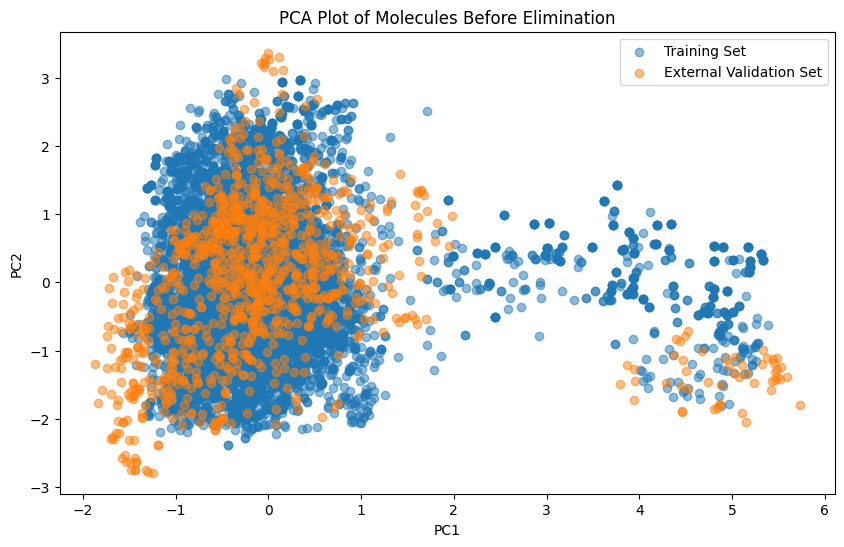

In [15]:
training_smiles = train_data['Smiles']  # List of SMILES strings for molecules in the training set
external_validation_smiles = external_data['Smiles']  # List of SMILES strings for molecules in the external validation set

# Calculate Morgan fingerprints for both sets
training_fingerprints = calculate_morgan_fingerprints(training_smiles)
external_validation_fingerprints = calculate_morgan_fingerprints(external_validation_smiles)

# Perform PCA
training_pca_result = perform_pca(training_fingerprints)
external_validation_pca_result = perform_pca(external_validation_fingerprints)

# Plot PCA-transformed molecules
plt.figure(figsize=(10, 6))
plt.scatter(training_pca_result[:, 0], training_pca_result[:, 1], label='Training Set', alpha=0.5)
plt.scatter(external_validation_pca_result[:, 0], external_validation_pca_result[:, 1], label='External Validation Set', alpha=0.5)
plt.title('PCA Plot of Molecules Before Elimination')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
#Save the plot
figure_path = '../figures/external_validation/pca_before_elimination.png'
plt.savefig(figure_path)
plt.show()

## Removing data leakage

In [16]:
external_data_filtered = external_data[~external_data['Smiles'].isin(train_data['standardised_smiles'])]

# Reset the index of the filtered DataFrame
external_data_filtered.reset_index(drop=True, inplace=True)

# Display the filtered DataFrame
external_data_filtered

,Smiles,InchiKeys,experimental_value
0,CC1CCCN1CCc1cc2cc(-c3cncc(C#N)c3)ccc2o1,UGELZTGBPPXJPE-UHFFFAOYSA-N,1
1,COc1ncc(-c2ccc(C3CC(N4CCCC4C)C3)cc2)cn1,DLNFWRTZALVTSJ-UHFFFAOYSA-N,1
2,COc1ncc(-c2ccc3cc(CCN4CCCC4C)ccc3c2)cn1,GCDHZFDHJDQKFR-UHFFFAOYSA-N,1
3,CC1CCCN1C1CC(c2ccc(-c3cncnc3)cc2)C1,XRYDMMOPQTWUSE-UHFFFAOYSA-N,1
4,O=C1NCN(c2ccccc2)C12CC[N+](CCCC(c1ccc(F)cc1)c1...,GFORFEKVQXJTEI-UHFFFAOYSA-N,1
...,...,...,...
557,CCC(=O)C(CC(C)[N+](C)C)(c1ccccc1)c1ccccc1,UHGHALWOVVUXKD-UHFFFAOYSA-N,0
558,CC(C)C(Oc1ccc(CNC(=O)C2CSCN2C(=O)CC(N)Cc2cc(F)...,GKMOQWBWMMGWKN-UHFFFAOYSA-N,0
559,CC1COc2c(N3CC[N+](C)CC3)c(F)cc3c(=O)c(C(=O)[O-...,KXKRZHKEPHLIGJ-UHFFFAOYSA-M,0
560,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,GSDSWSVVBLHKDQ-UHFFFAOYSA-N,0


## Visualizing repeated molecules after elimination

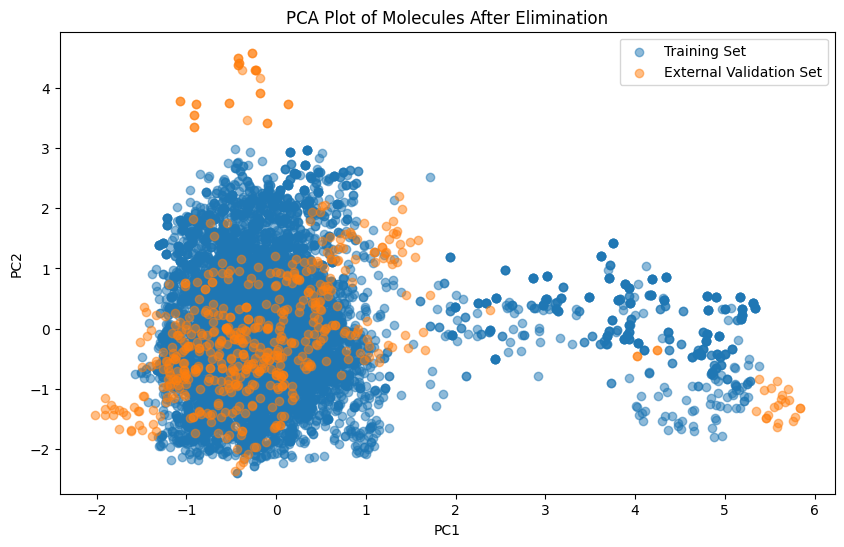

In [17]:
training_smiles = train_data['Smiles'] 
external_validation_smiles = external_data_filtered['Smiles']

# Calculate Morgan fingerprints for both sets
training_fingerprints = calculate_morgan_fingerprints(training_smiles)
external_validation_fingerprints = calculate_morgan_fingerprints(external_validation_smiles)

# Perform PCA
training_pca_result = perform_pca(training_fingerprints)
external_validation_pca_result = perform_pca(external_validation_fingerprints)

# Plot PCA-transformed molecules
plt.figure(figsize=(10, 6))
plt.scatter(training_pca_result[:, 0], training_pca_result[:, 1], label='Training Set', alpha=0.5)
plt.scatter(external_validation_pca_result[:, 0], external_validation_pca_result[:, 1], label='External Validation Set', alpha=0.5)
plt.title('PCA Plot of Molecules After Elimination')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
#Save the plot
figure_path = '../figures/external_validation/pca_after_elimination.png'
plt.savefig(figure_path)
plt.show()

The `external_data_filtered` dataframe contains the data without any repeated molecule.

# Number of blockers and non-blockers in the external data

In [18]:
# Calculate classification counts
prediction_classification_counts = external_data_filtered['experimental_value'].value_counts()

# Calculate percentage of classification counts
total_count = prediction_classification_counts.sum()
percentage = (prediction_classification_counts / total_count) * 100

# Create PrettyTable
prediction_table = PrettyTable()
prediction_table.field_names = ['Blockers', 'Number', 'Percentage']

# Add rows to the table
prediction_table.add_row(['Yes', prediction_classification_counts[1], f"{percentage[1]:.2f}%"])
prediction_table.add_row(['No', prediction_classification_counts[0], f"{percentage[0]:.2f}%"])

# Print the table
print(prediction_table)

+----------+--------+------------+
| Blockers | Number | Percentage |
+----------+--------+------------+
|   Yes    |  123   |   21.89%   |
|    No    |  439   |   78.11%   |
+----------+--------+------------+


Now, we will check whether the model is able to reproduce this table. If it is able to do so, then it will be validated that the model is predicting the correct outputs.

In [19]:
# Save the filtered DataFrame as a CSV file
external_data_filtered.to_csv('../data/input_task3.csv', index=False)

# Running the model on Ersilia Model Hub with the external data

The model is run on the terminal on the input data using the following commands:
```
ersilia -v fetch eos30gr
ersilia serve eos30gr
ersilia -v api run -i input_task3.csv -o output_task3.json
```
The output after running the model is saved in `output_task2.json` file which is present the `data` directory.

# Exploring model predictions

## Loading model predictions

We will first convert the json data to required csv format.

In [20]:
json_data = pd.read_json('../data/output_task3.json')

In [21]:
json_data.head()

,input,output
0,"{'key': 'UGELZTGBPPXJPE-UHFFFAOYSA-N', 'input'...",{'outcome': 0.9265676736831661}
1,"{'key': 'DLNFWRTZALVTSJ-UHFFFAOYSA-N', 'input'...",{'outcome': 0.9752475023269651}
2,"{'key': 'GCDHZFDHJDQKFR-UHFFFAOYSA-N', 'input'...",{'outcome': 0.9628713130950921}
3,"{'key': 'XRYDMMOPQTWUSE-UHFFFAOYSA-N', 'input'...",{'outcome': 0.9801980257034301}
4,"{'key': 'GFORFEKVQXJTEI-UHFFFAOYSA-N', 'input'...",{'outcome': 0.9405940771102901}


In [22]:
json_input = pd.json_normalize(json_data['input'])
json_output = pd.json_normalize(json_data['output'])

In [23]:
df = pd.merge(json_input ,json_output ,left_index=True, right_index=True, how='inner')

In [24]:
df.head()

,key,input,text,outcome
0,UGELZTGBPPXJPE-UHFFFAOYSA-N,CC1CCCN1CCc1cc2cc(-c3cncc(C#N)c3)ccc2o1,CC1CCCN1CCc1cc2cc(-c3cncc(C#N)c3)ccc2o1,0.926568
1,DLNFWRTZALVTSJ-UHFFFAOYSA-N,COc1ncc(-c2ccc(C3CC(N4CCCC4C)C3)cc2)cn1,COc1ncc(-c2ccc(C3CC(N4CCCC4C)C3)cc2)cn1,0.975248
2,GCDHZFDHJDQKFR-UHFFFAOYSA-N,COc1ncc(-c2ccc3cc(CCN4CCCC4C)ccc3c2)cn1,COc1ncc(-c2ccc3cc(CCN4CCCC4C)ccc3c2)cn1,0.962871
3,XRYDMMOPQTWUSE-UHFFFAOYSA-N,CC1CCCN1C1CC(c2ccc(-c3cncnc3)cc2)C1,CC1CCCN1C1CC(c2ccc(-c3cncnc3)cc2)C1,0.980198
4,GFORFEKVQXJTEI-UHFFFAOYSA-N,O=C1NCN(c2ccccc2)C12CC[N+](CCCC(c1ccc(F)cc1)c1...,O=C1NCN(c2ccccc2)C12CC[N+](CCCC(c1ccc(F)cc1)c1...,0.940594


In [25]:
df.drop('text', axis=1, inplace=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 562 entries, 0 to 561
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      562 non-null    object 
 1   input    562 non-null    object 
 2   outcome  562 non-null    float64
dtypes: float64(1), object(2)
memory usage: 13.3+ KB


In [27]:
# Saving df as a CSV file
df.to_csv('../data/output_task3.csv', index=False)

## Classifying the model predictions

Using threshold value as 0.5 for the predicted probabilities, i.e., outcome >= 0.5 will be classified as a hERG blocker.

In [28]:
df['Predicted classification'] = np.where(df['outcome'] >= 0.5, 1, 0)
df.head()

,key,input,outcome,Predicted classification
0,UGELZTGBPPXJPE-UHFFFAOYSA-N,CC1CCCN1CCc1cc2cc(-c3cncc(C#N)c3)ccc2o1,0.926568,1
1,DLNFWRTZALVTSJ-UHFFFAOYSA-N,COc1ncc(-c2ccc(C3CC(N4CCCC4C)C3)cc2)cn1,0.975248,1
2,GCDHZFDHJDQKFR-UHFFFAOYSA-N,COc1ncc(-c2ccc3cc(CCN4CCCC4C)ccc3c2)cn1,0.962871,1
3,XRYDMMOPQTWUSE-UHFFFAOYSA-N,CC1CCCN1C1CC(c2ccc(-c3cncnc3)cc2)C1,0.980198,1
4,GFORFEKVQXJTEI-UHFFFAOYSA-N,O=C1NCN(c2ccccc2)C12CC[N+](CCCC(c1ccc(F)cc1)c1...,0.940594,1


## Number of blockers and non-blockers in the predictions

In [29]:
# Calculate classification counts
prediction_classification_counts = df['Predicted classification'].value_counts()

# Calculate percentage of classification counts
total_count = prediction_classification_counts.sum()
percentage = (prediction_classification_counts / total_count) * 100

# Create PrettyTable
prediction_table = PrettyTable()
prediction_table.field_names = ['Blockers', 'Number', 'Percentage']

# Add rows to the table
prediction_table.add_row(['Yes', prediction_classification_counts[1], f"{percentage[1]:.2f}%"])
prediction_table.add_row(['No', prediction_classification_counts[0], f"{percentage[0]:.2f}%"])

# Print the table
print(prediction_table)

+----------+--------+------------+
| Blockers | Number | Percentage |
+----------+--------+------------+
|   Yes    |  378   |   67.26%   |
|    No    |  184   |   32.74%   |
+----------+--------+------------+


We can see that the percentage of blockers and non-blockers in the predictions differ significantly from the external dataset. This means that the model cannot be validated. We will now proceed and find the performance metrics.

# Checking performance metrics

## Defining true labels and predicted labels

In [30]:
true_labels = external_data_filtered['experimental_value']
predicted_labels = df['Predicted classification']

## Calculating confusion matrix

In [31]:
cm = confusion_matrix(true_labels, predicted_labels)

# Extract TP, TN, FP, FN
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

## Calculating performance metrics

In [32]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Calculate precision
precision = precision_score(true_labels, predicted_labels)

# Calculate recall (sensitivity)
recall = recall_score(true_labels, predicted_labels)

# Calculate specificity
specificity = TN / (TN + FP)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)

# Calculate AUROC
auroc = roc_auc_score(true_labels, predicted_labels)

## Plotting Confusion Matrix

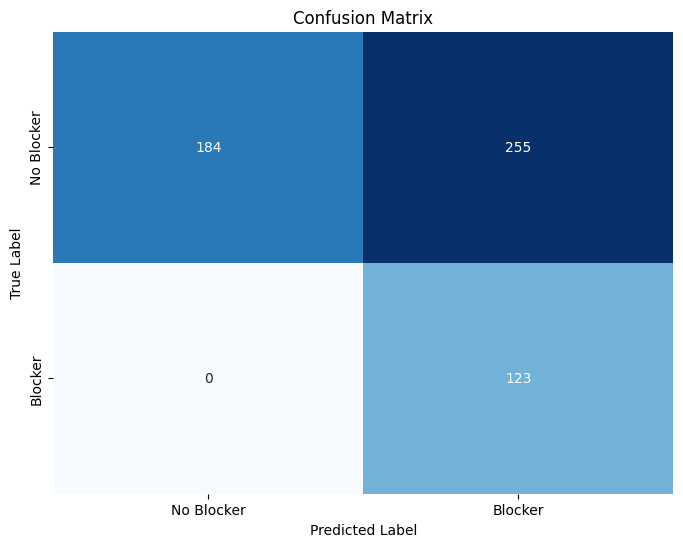

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Blocker", "Blocker"],
            yticklabels=["No Blocker", "Blocker"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
#Save the plot
figure_path = '../figures/external_validation/confusion_matrix.png'
plt.savefig(figure_path)
plt.show()

## Accuracy, Precision, Recall, F1 Score, AUROC

In [34]:
metrics_table = PrettyTable()
metrics_table.field_names = ["Metric", "Value"]
metrics_table.add_row(["Accuracy", round(accuracy, 4)])
metrics_table.add_row(["Precision", round(precision, 4)])
metrics_table.add_row(["Recall", round(recall, 4)])
metrics_table.add_row(["Specificity", round(specificity, 4)])
metrics_table.add_row(["F1 Score", round(f1, 4)])
metrics_table.add_row(["AUROC", round(auroc, 4)])

# Transpose the table
metrics_table_transposed = PrettyTable(["Metric", "Accuracy", "Precision", "Recall", "Specificity", "F1 Score", "AUROC"])
metrics_table_transposed.add_row(["Value"] + [round(accuracy, 4), round(precision, 4), round(recall, 4),
                                             round(specificity, 4), round(f1, 4), round(auroc, 4)])

# Print the transposed table
print(metrics_table_transposed)

+--------+----------+-----------+--------+-------------+----------+--------+
| Metric | Accuracy | Precision | Recall | Specificity | F1 Score | AUROC  |
+--------+----------+-----------+--------+-------------+----------+--------+
| Value  |  0.5463  |   0.3254  |  1.0   |    0.4191   |  0.491   | 0.7096 |
+--------+----------+-----------+--------+-------------+----------+--------+


## Plotting AUROC Curve

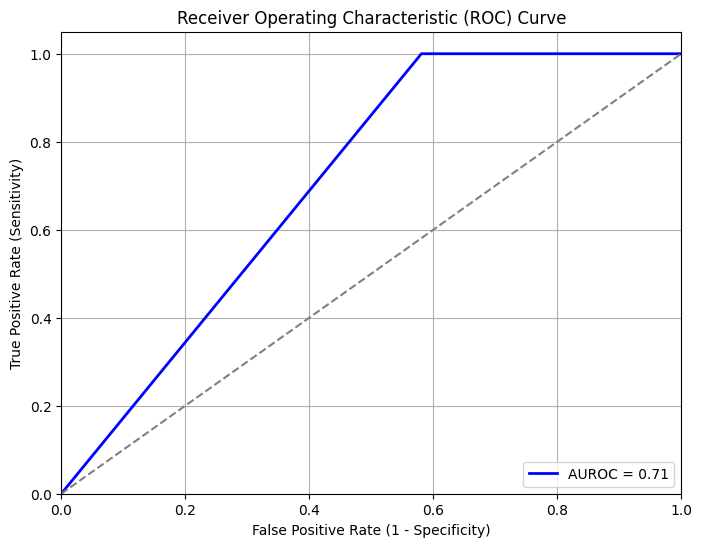

In [35]:
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
auc = roc_auc_score(true_labels, predicted_labels)

# Plot AUROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='AUROC = %0.2f' % auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
#Save the plot
figure_path = '../figures/external_validation/auroc_curve.png'
plt.savefig(figure_path)
plt.show()

# Conclusion

- Accuracy: The model's overall accuracy is 54.63%, indicating that it correctly predicts the outcome for approximately 54.63% of the samples.

- Precision: The precision of the model is 32.54%, meaning that when it predicts a molecule as a blocker, it is correct only 32.54% of the time.

- Recall: The recall rate is 100%, indicating that the model correctly identifies all blockers in the dataset. This suggests that the model effectively captures all positive instances but may have a high rate of false positives.

- Specificity: The specificity of the model is 41.91%, indicating that it correctly identifies non-blockers around 41.91% of the time.

- F1 Score: The F1 score, which is the harmonic mean of precision and recall, is 0.491, providing a balanced measure of the model's performance.

- AUROC: The area under the receiver operating characteristic curve (AUROC) is 0.7096, which suggests that the model performs moderately well in classifying instances into the correct classes. The model may not be as reliable as desired in certain contexts, and there may be areas where it struggles to correctly classify instances.

__These metrics suggest that the model is not able to validate the results of the external dataset.__